In [1]:
import sys
sys.path.append("../scripts")


import data
import utils
import experiments
from models import dual_obj_1, get_subgroup_indicator, logloss_group, logloss_grad, logloss_hessian, logloss_group_grad, logloss_group_hess

import numpy as np
import pandas as pd
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from fairgbm import FairGBMClassifier


%load_ext autoreload
%autoreload 2

## Helper functions

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import logging
class CustomLogger:
    def __init__(self):
        self.logger = logging.getLogger('lightgbm_custom')
        self.logger.setLevel(logging.ERROR)

    def info(self, message):
        self.logger.info(message)

    def warning(self, message):
        # Suppress warnings by not doing anything
        pass

    def error(self, message):
        self.logger.error(message)
import lightgbm as lgb
lgb.register_logger(CustomLogger())


class M2FGB(BaseEstimator, ClassifierMixin):
    """Classifier that modifies LGBM to incorporate min-max fairness optimization.
    It shares many of the parameters with LGBM to control learning and decision trees.
    The fairness metrics impelemented are "equalized_loss", "equal_opportunity", and "demographic_parity".
    
    Parameters
    ----------
    fairness_constraint : str, optional
        Fairness constraint used in learning, must be ["equalized_loss", "equal_opportunity", "demographic_parity"], by default "equalized_loss"
    fair_weight : int, optional
        Weight for fairness in loss formulation, by default 1
    dual_learning : str, optional
        Method used to learn the dual problem, must be ["optim", "grad"], by default "optim"
    multiplier_learning_rate: float, optional
        Learning rate used in the gradient learning of the dual, used only if dual_learning="gradient", by default 0.1
    n_estimators : int, optional
        Number of estimators used in XGB, by default 10
    learning_rate : float, optional
        Learning rate of ensambles, by default 0.1
    max_depth : int, optional
        Max depth of decision trees, by default 6
    min_child_weight : int, optional
        Weight used to choose partition of tree nodes, by default 1
    reg_lambda : int, optional
        Weight of L2 regularization, by default 1
    random_state : int, optional
        Random seed used in learning, by default None
    """

    def __init__(
        self,
        fairness_constraint="equalized_loss",
        fair_weight=1,
        dual_learning="optim",
        multiplier_learning_rate=0.1,
        n_estimators=10,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        reg_lambda=1,
        random_state=None,
    ):
        assert fairness_constraint in [
            "equalized_loss",
            "equal_opportunity",
            "demographic_parity",
        ]
        assert dual_learning in ["optim", "gradient"]

        self.fairness_constraint = fairness_constraint
        self.dual_learning = dual_learning
        self.multiplier_learning_rate = multiplier_learning_rate
        self.fair_weight = fair_weight
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.reg_lambda = reg_lambda
        self.random_state = random_state
        

    def fit(self, X, y, sensitive_attribute):
        """Fit the model to the data.

        Parameters
        ----------
        X : pandas.DataFrame
            Dataframe of shape (n_samples, n_features)
        y : pandas.Series or numpy.ndarray
            Labels array-like of shape (n_samples), must be (0 or 1)
        sensitive_attribute : pandas.Series or numpy.ndarray
            Sensitive attribute array-like of shape (n_samples)

        Returns
        -------
        M2FGB
            Fitted model
        """
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self.group_losses = []
        self.mu_opt_list = [None]
        dtrain = lgb.Dataset(X, label=y)

        params = {
            "objective": dual_obj_1(
                sensitive_attribute,
                self.fair_weight,
                self.group_losses,
                self.mu_opt_list,
                self.fairness_constraint,
                self.dual_learning,
                self.multiplier_learning_rate,
            ),
            "learning_rate": self.learning_rate,
            "max_depth": self.max_depth,
            "min_child_weight": self.min_child_weight,
            "reg_lambda": self.reg_lambda,
            "verbose": -1,
        }
        if self.random_state is not None:
            params["random_seed"] = self.random_state

        self.model_ = lgb.train(
            params,
            dtrain,
            num_boost_round=self.n_estimators,
        )
        self.group_losses = np.array(self.group_losses)
        self.mu_opt_list = np.array(self.mu_opt_list)
        return self

    def predict(self, X):
        """Predict the labels of the data."""
        check_is_fitted(self)
        X = check_array(X)
        log_odds = self.model_.predict(X)
        preds = 1 / (1 + np.exp(-log_odds))
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        """Predict the probabilities of the data."""
        check_is_fitted(self)
        X = check_array(X)
        log_odds = self.model_.predict(X)
        preds_pos = 1 / (1 + np.exp(-log_odds))
        preds = np.ones((preds_pos.shape[0], 2))
        preds[:, 1] = preds_pos
        preds[:, 0] -= preds_pos
        return preds


In [3]:
def get_subgroup_indicator_test(subgroup):
    groups = np.unique(subgroup)
    I = np.zeros((subgroup.shape[0], len(groups)))
    n_g_max = -np.inf
    for i, g in enumerate(groups):
        n_g = np.sum(subgroup == g)
        n_g_max = max(n_g_max, n_g)
        I[subgroup == g, i] = 1 / np.sum(subgroup == g)   
    
    I = I * n_g_max
    return I

In [4]:
def logloss_group_test(predt, dtrain, subgroup, fairness_constraint):
    """For each subgroup, calculates the mean log loss of the samples."""
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    predt = np.clip(predt, 1e-7, 1 - 1e-7)  # avoid log(0)
    if fairness_constraint == "equalized_loss":
        loss = -(y * np.log(predt) + (1 - y) * np.log(1 - predt))
    if fairness_constraint == "demographic_parity":
        y_ = np.ones(y.shape[0])  # all positive class
        loss = -(y_ * np.log(predt) + (1 - y_) * np.log(1 - predt))
    elif fairness_constraint == "equal_opportunity":
        loss = -(y * np.log(predt) + (1 - y) * np.log(1 - predt))
        loss[y == 0] = 0  # only consider the loss of the positive class

    loss = np.array([np.mean(loss[subgroup == g]) for g in np.unique(subgroup)])
    return loss

def logloss_group_grad_test(predt, dtrain, fairness_constraint):
    """Create a matrix with the gradient for each subgroup in each column."""
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    if fairness_constraint == "equalized_loss":
        grad = -(y - predt)
    elif fairness_constraint == "demographic_parity":
        y_ = np.ones(y.shape[0])  # all positive class
        grad = -(y_ - predt)
    elif fairness_constraint == "equal_opportunity":
        grad = -(y - predt)
        grad[y == 0] = 0  # only consider the loss of the positive class

    return grad


def logloss_group_hess_test(predt, dtrain, fairness_constraint):
    """Create a matrix with the hessian for each subgroup in each column."""
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    if fairness_constraint == "equalized_loss":
        hess = predt * (1 - predt)
    elif (
        fairness_constraint == "demographic_parity"
        or fairness_constraint == "equal_opportunity"
    ):
        hess = predt * (1 - predt)
        hess[y == 0] = 0  # only consider the loss of the positive class
    
    return hess


def dual_obj_test(
    subgroup,
    group_losses,
    mu_opt_list,
    fairness_constraint="equalized_loss",
    dual_learning="optim",
    multiplier_learning_rate=0.1,
):
    I = get_subgroup_indicator_test(subgroup)

    def custom_obj(predt, dtrain):
        loss_group = logloss_group_test(predt, dtrain, subgroup, fairness_constraint)
        if len(mu_opt_list) > 1:
            group_losses.append(loss_group)
        
        if dual_learning == "optim":
            # dual problem solved analytically
            idx_biggest_loss = np.where(loss_group == np.max(loss_group))[0]
            # if is more than one, randomly choose one
            idx_biggest_loss = np.random.choice(idx_biggest_loss)
            mu_opt = np.zeros(loss_group.shape[0])
            mu_opt[idx_biggest_loss] = 1
            if mu_opt_list[0] is None:
                mu_opt_list[0] = mu_opt
            else:
                mu_opt_list.append(mu_opt)

        elif dual_learning == "gradient":
            if mu_opt_list[0] is None:
                mu_opt = np.zeros(loss_group.shape[0])
                mu_opt_list[0] = mu_opt

            else:
                mu_opt = mu_opt_list[-1].copy()
                mu_opt += multiplier_learning_rate * loss_group
                mu_opt_list.append(mu_opt)

        elif dual_learning == "gradient_norm":
            if mu_opt_list[0] is None:
                mu_opt = np.ones(loss_group.shape[0])
                mu_opt = mu_opt / np.sum(mu_opt)
                mu_opt_list[0] = mu_opt

            else:
                mu_opt = mu_opt_list[-1].copy()
                mu_opt += multiplier_learning_rate * loss_group
                mu_opt = mu_opt / np.sum(mu_opt)
                mu_opt_list.append(mu_opt)


        grad = logloss_group_grad_test(predt, dtrain, fairness_constraint)
        grad = I * grad.reshape(-1, 1) @ mu_opt

        hess = logloss_group_hess_test(predt, dtrain, fairness_constraint)
        hess = I * hess.reshape(-1, 1) @ mu_opt

        return grad, hess

    return custom_obj



class M2FGB_test(BaseEstimator, ClassifierMixin):
    """Classifier that modifies LGBM to incorporate min-max fairness optimization.
    It shares many of the parameters with LGBM to control learning and decision trees.
    The fairness metrics impelemented are "equalized_loss", "equal_opportunity", and "demographic_parity".
    
    Parameters
    ----------
    fairness_constraint : str, optional
        Fairness constraint used in learning, must be ["equalized_loss", "equal_opportunity", "demographic_parity"], by default "equalized_loss"
    fair_weight : int, optional
        Weight for fairness in loss formulation, by default 1
    dual_learning : str, optional
        Method used to learn the dual problem, must be ["optim", "grad"], by default "optim"
    multiplier_learning_rate: float, optional
        Learning rate used in the gradient learning of the dual, used only if dual_learning="gradient", by default 0.1
    n_estimators : int, optional
        Number of estimators used in XGB, by default 10
    learning_rate : float, optional
        Learning rate of ensambles, by default 0.1
    max_depth : int, optional
        Max depth of decision trees, by default 6
    min_child_weight : int, optional
        Weight used to choose partition of tree nodes, by default 1
    reg_lambda : int, optional
        Weight of L2 regularization, by default 1
    random_state : int, optional
        Random seed used in learning, by default None
    """

    def __init__(
        self,
        fairness_constraint="equalized_loss",
        dual_learning="optim",
        multiplier_learning_rate=0.1,
        n_estimators=10,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        reg_lambda=1,
        random_state=None,
    ):
        assert fairness_constraint in [
            "equalized_loss",
            "equal_opportunity",
            "demographic_parity",
        ]
        assert dual_learning in ["optim", "gradient", "gradient_norm"]

        self.fairness_constraint = fairness_constraint
        self.dual_learning = dual_learning
        self.multiplier_learning_rate = multiplier_learning_rate
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.reg_lambda = reg_lambda
        self.random_state = random_state
        

    def fit(self, X, y, sensitive_attribute):
        """Fit the model to the data.

        Parameters
        ----------
        X : pandas.DataFrame
            Dataframe of shape (n_samples, n_features)
        y : pandas.Series or numpy.ndarray
            Labels array-like of shape (n_samples), must be (0 or 1)
        sensitive_attribute : pandas.Series or numpy.ndarray
            Sensitive attribute array-like of shape (n_samples)

        Returns
        -------
        M2FGB
            Fitted model
        """
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self.group_losses = []
        self.mu_opt_list = [None]
        dtrain = lgb.Dataset(X, label=y)

        params = {
            "objective": dual_obj_test(
                sensitive_attribute,
                self.group_losses,
                self.mu_opt_list,
                self.fairness_constraint,
                self.dual_learning,
                self.multiplier_learning_rate,
            ),
            "learning_rate": self.learning_rate,
            "max_depth": self.max_depth,
            "min_child_weight": self.min_child_weight,
            "reg_lambda": self.reg_lambda,
            "verbose": -1,
        }
        if self.random_state is not None:
            params["random_seed"] = self.random_state

        self.model_ = lgb.train(
            params,
            dtrain,
            num_boost_round=self.n_estimators,
        )
        self.group_losses = np.array(self.group_losses)
        self.mu_opt_list = np.array(self.mu_opt_list)
        return self

    def predict(self, X):
        """Predict the labels of the data."""
        check_is_fitted(self)
        X = check_array(X)
        log_odds = self.model_.predict(X)
        preds = 1 / (1 + np.exp(-log_odds))
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        """Predict the probabilities of the data."""
        check_is_fitted(self)
        X = check_array(X)
        log_odds = self.model_.predict(X)
        preds_pos = 1 / (1 + np.exp(-log_odds))
        preds = np.ones((preds_pos.shape[0], 2))
        preds[:, 1] = preds_pos
        preds[:, 0] -= preds_pos
        return preds

In [5]:
def plot_model_result(model):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 5))

    x = np.arange(model.mu_opt_list.shape[0])
    for i in range(model.group_losses.shape[1]):
        axs[0].plot(x[2:], model.group_losses[:, i], label=f"Group {i}")
        axs[1].plot(x[3:], np.diff(model.group_losses[:, i]), label=f"Group {i}", alpha = 0.5)
        if len(np.unique(model.mu_opt_list)) == 2:
            axs[2].scatter(
                x, 
                model.mu_opt_list[:, i] + np.random.uniform(0, 0.1, model.mu_opt_list.shape[0]),
                label=f"Group {i}",
                alpha = 0.25
            )
            axs[2].set_title("$\mu + U(0, 0.1)$")
        else:
            axs[2].plot(x, model.mu_opt_list[:, i], label=f"Group {i}")
            axs[2].set_title("$\mu$")

    axs[0].set_title("Group logloss")
    axs[1].set_title("diff(Group logloss)")
    

    for i in range(3):
        axs[i].legend()
        axs[i].grid()
        axs[i].set_xlabel("Iteration")

    # get 10%-90% quantile range of the np.diff(model.group_losses)
    ndiff = np.concatenate([
        np.diff(model.group_losses[:, i]) for i in range(model.group_losses.shape[1])
    ])
    axs[1].set_ylim(np.quantile(ndiff, 0.05), np.quantile(ndiff, 0.95))

    plt.show()

## Loading data

In [6]:
dataset = "adult"

In [7]:
X_train, Y_train, X_val, Y_val, X_test, Y_test =  data.get_fold(dataset, 3, 10, 0)
A_train, A_val, A_test = experiments.get_subgroup_feature(dataset, X_train, X_val, X_test, 4)

{'Male_True': 0, 'Male_False': 1, 'Female_False': 2, 'Female_True': 3}


In [8]:
col_trans = ColumnTransformer(
    [
        ("numeric", StandardScaler(), data.NUM_FEATURES[dataset]),
        (
            "categorical",
            OneHotEncoder(
                drop="if_binary", sparse_output=False, handle_unknown="ignore"
            ),
            data.CAT_FEATURES[dataset],
        ),
    ],
    verbose_feature_names_out=False,
)
col_trans.set_output(transform="pandas")

preprocess = Pipeline([("preprocess", col_trans)])
preprocess.fit(X_train)
X_train = preprocess.transform(X_train)
X_val = preprocess.transform(X_val)
X_test = preprocess.transform(X_test)

## Testing M²FGB with only fairness

In [9]:
model = M2FGB_test(n_estimators=500, min_child_weight=1, learning_rate = 0.1)
model.fit(X_train, Y_train, A_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

M2FGB_test(n_estimators=500)

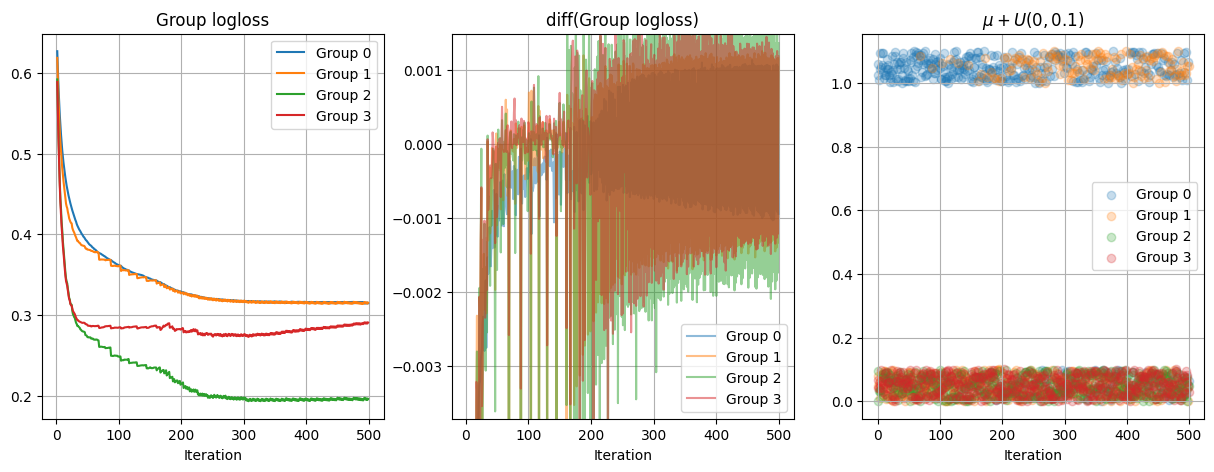

In [11]:
plot_model_result(model)

In [82]:
model = M2FGB_test(n_estimators=500, min_child_weight=1, learning_rate = 0.1, dual_learning = "gradient", multiplier_learning_rate = 0.1)
model.fit(X_train, Y_train, A_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

M2FGB_test(dual_learning='gradient', n_estimators=500)

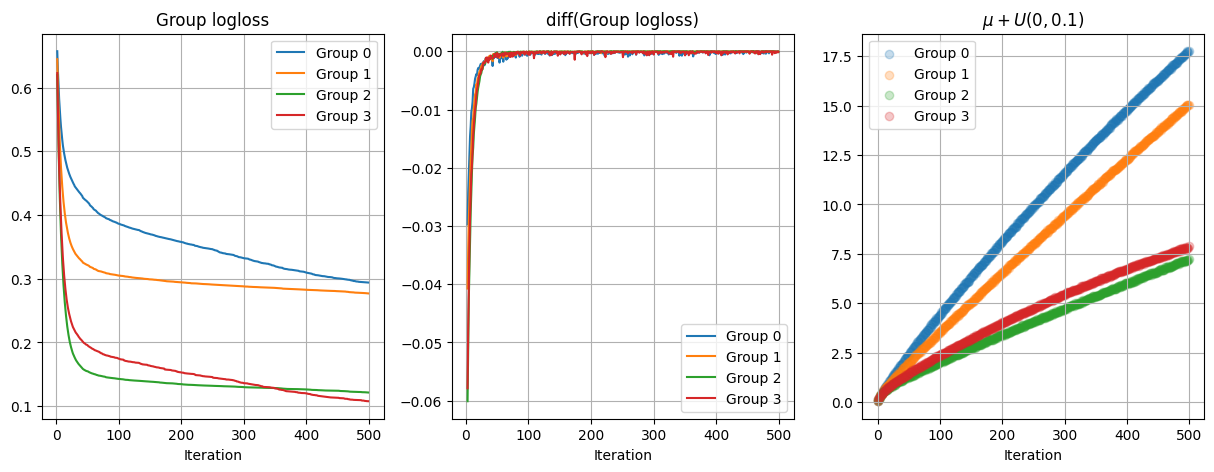

In [83]:
plot_model_result(model)

In [90]:
model = M2FGB_test(n_estimators=500, min_child_weight=1, learning_rate = 0.1, dual_learning = "gradient_norm", multiplier_learning_rate = 0.1)
model.fit(X_train, Y_train, A_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

M2FGB_test(dual_learning='gradient_norm', n_estimators=500)

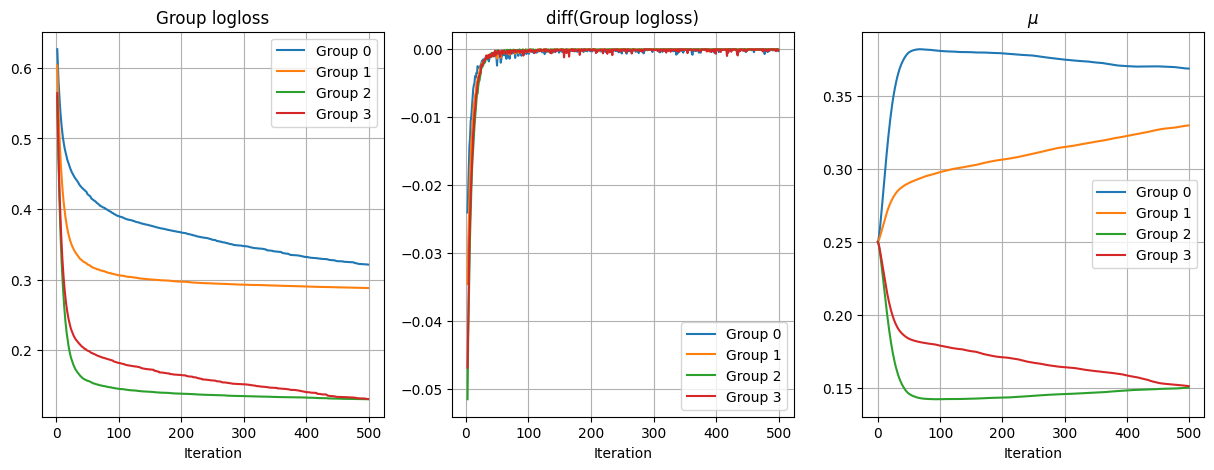

In [97]:
plot_model_result(model)

In [12]:
def get_metrics(Y_target, Y_pred, A):
    metrics = {
        "bal_acc" : utils.balanced_accuracy_score(Y_target, Y_pred),
        "roc" : utils.roc_auc_score(Y_target, Y_pred),
        "eod" : utils.equal_opportunity_score(Y_target, Y_pred, A),
        "min_bal_acc" : 1 - utils.min_balanced_accuracy(Y_target, Y_pred, A),
    }
    return metrics

## Evaluate at some folder with hyper-param tuning

In [10]:
scorer = utils.get_combined_metrics_scorer(
    alpha=0., performance_metric="bal_acc", fairness_metric="min_bal_acc"
)

In [11]:
param_spaces = {}
for model_name in ["LGBMClassifier", "FairGBMClassifier"]:
    param_spaces[model_name] = experiments.get_param_spaces(model_name)
    #param_spaces[model_name]["n_estimators"] = {"type" : "int", "low" : 250, "high":250}
    #param_spaces[model_name]["learning_rate"] = {"type" : "float", "low" : 0.1, "high":0.1}

param_spaces["M2FGB_test"] = experiments.get_param_spaces("M2FGB").copy()
param_spaces["M2FGB_grad_test"] = experiments.get_param_spaces("M2FGB_grad").copy()
param_spaces["M2FGB_grad_norm_test"] = experiments.get_param_spaces("M2FGB_grad").copy()
del param_spaces["M2FGB_test"]["fair_weight"]
del param_spaces["M2FGB_grad_test"]["fair_weight"]
del param_spaces["M2FGB_grad_norm_test"]["fair_weight"]

In [ ]:
best_params = {}
best_models = {}
results = []
for model_name in ["LGBMClassifier", "FairGBMClassifier", "M2FGB_test", "M2FGB_grad_test", "M2FGB_grad_norm_test"]:
    if model_name == "M2FGB_test":
        def model_(**params):
            return M2FGB_test(random_state=0, **params)
        model_class = model_
    elif model_name == "M2FGB_grad_test":
        def model_(**params):
            return M2FGB_test(random_state=0, dual_learning="gradient", **params)
        model_class = model_
    elif model_name == "M2FGB_grad_norm_test":
        def model_(**params):
            return M2FGB_test(random_state=0, dual_learning="gradient_norm", **params)
        model_class = model_
    else:
        model_class = experiments.get_model(model_name, random_state=0)

    study = optuna.create_study(direction="maximize")
    objective = lambda trial: experiments.run_trial(
        trial,
        scorer,
        X_train,
        Y_train,
        A_train,
        X_val,
        Y_val,
        A_val,
        model_class,
        param_spaces[model_name],
        {"thresh" : 0.5},
    )
    study.optimize(objective, n_trials=100, n_jobs=-1)
    best_params[model_name] = study.best_params.copy()

    model = model_class(**best_params[model_name])
    if model_name == "LGBMClassifier":
        model.fit(X_train, Y_train)
    elif model_name == "FairGBMClassifier":
        model.fit(X_train, Y_train, constraint_group = A_train)
    else:
        model.fit(X_train, Y_train, A_train)

    best_models[model_name] = model
    Y_train_pred = model.predict(X_train) > 0.5
    Y_val_pred = model.predict(X_val) > 0.5
    Y_test_pred = model.predict(X_test) > 0.5

    results.append(get_metrics(Y_train, Y_train_pred, A_train))
    results[-1]["set"] = "train"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_val, Y_val_pred, A_val))
    results[-1]["set"] = "val"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_test, Y_test_pred, A_test))
    results[-1]["set"] = "test"
    results[-1]["model"] = model_name


results = pd.DataFrame(results)

In [24]:
results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))

/tmp/ipykernel_4243/3152775685.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))


bal_acc       roc       eod  min_bal_acc    set  \
set                                                          
test  2   0.809378  0.809378  0.123127     0.777992   test   
      11  0.816460  0.816460  0.139415     0.777992   test   
      5   0.795924  0.795924  0.246701     0.762950   test   
      14  0.803849  0.803849  0.153529     0.752413   test   
      8   0.785075  0.785075  0.222461     0.707046   test   
train 12  0.874629  0.874629  0.151397     0.846961  train   
      0   0.855524  0.855524  0.099269     0.837405  train   
      9   0.820756  0.820756  0.123513     0.807143  train   
      3   0.795019  0.795019  0.168914     0.769724  train   
      6   0.811337  0.811337  0.218346     0.750495  train   
val   7   0.782386  0.782386  0.104012     0.760377    val   
      4   0.783938  0.783938  0.088693     0.754785    val   
      13  0.792138  0.792138  0.203180     0.736792    val   
      1   0.797237  0.797237  0.231714     0.731840    val   
      10  0.796021  0.796021  0.210512     0.726179    val   

                         model  
set                             
test  2         LGBMClassifier  
      11       M2FGB_grad_test  
      5      FairGBMClassifier  
      14  M2FGB_grad_norm_test  
      8             M2FGB_test  
train 12  M2FGB_grad_norm_test  
      0         LGBMClassifier  
      9        M2FGB_grad_test  
      3      FairGBMClassifier  
      6             M2FGB_test  
val   7             M2FGB_test  
      4      FairGBMClassifier  
      13  M2FGB_grad_norm_test  
      1         LGBMClassifier  
      10       M2FGB_grad_test

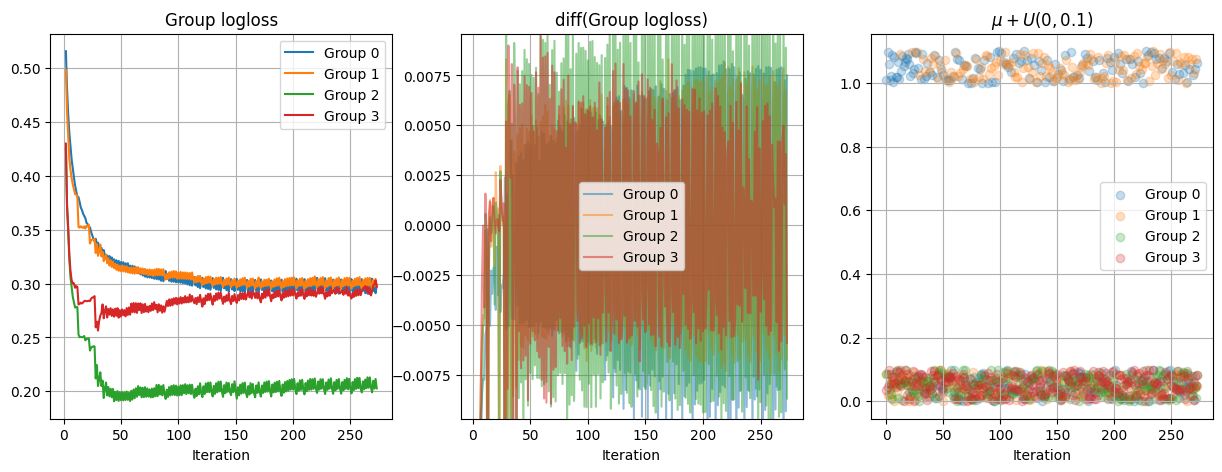

In [51]:
plot_model_result(best_models["M2FGB_test"])

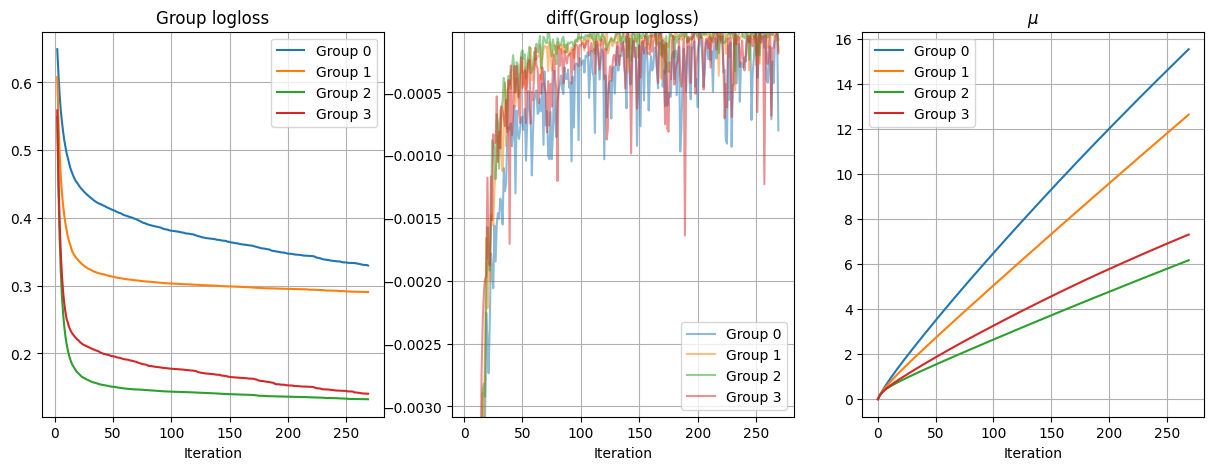

In [52]:
plot_model_result(best_models["M2FGB_grad_test"])

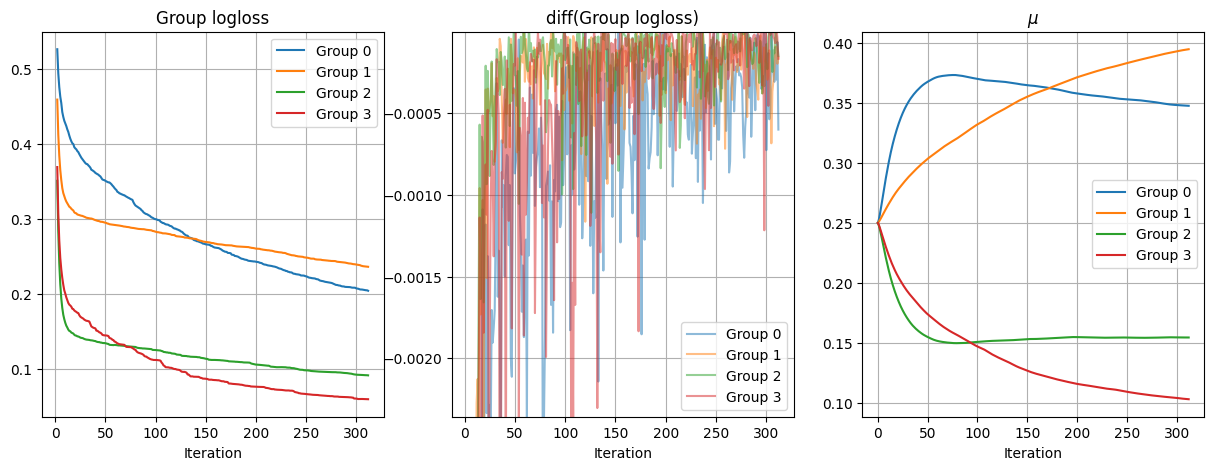

In [53]:
plot_model_result(best_models["M2FGB_grad_norm_test"])

## Hyperparam tuning for performance

In [13]:
scorer = utils.get_combined_metrics_scorer(
    alpha=1, performance_metric="bal_acc", fairness_metric="min_bal_acc"
)

In [14]:
param_spaces = {}
for model_name in ["LGBMClassifier", "FairGBMClassifier"]:
    param_spaces[model_name] = experiments.get_param_spaces(model_name)
    #param_spaces[model_name]["n_estimators"] = {"type" : "int", "low" : 250, "high":250}
    #param_spaces[model_name]["learning_rate"] = {"type" : "float", "low" : 0.1, "high":0.1}

param_spaces["M2FGB_test"] = experiments.get_param_spaces("M2FGB").copy()
param_spaces["M2FGB_grad_test"] = experiments.get_param_spaces("M2FGB_grad").copy()
param_spaces["M2FGB_grad_norm_test"] = experiments.get_param_spaces("M2FGB_grad").copy()
del param_spaces["M2FGB_test"]["fair_weight"]
del param_spaces["M2FGB_grad_test"]["fair_weight"]
del param_spaces["M2FGB_grad_norm_test"]["fair_weight"]

In [ ]:
best_params = {}
best_models = {}
results = []
for model_name in ["LGBMClassifier", "FairGBMClassifier", "M2FGB_test", "M2FGB_grad_test", "M2FGB_grad_norm_test"]:
    if model_name == "M2FGB_test":
        def model_(**params):
            return M2FGB_test(random_state=0, **params)
        model_class = model_
    elif model_name == "M2FGB_grad_test":
        def model_(**params):
            return M2FGB_test(random_state=0, dual_learning="gradient", **params)
        model_class = model_
    elif model_name == "M2FGB_grad_norm_test":
        def model_(**params):
            return M2FGB_test(random_state=0, dual_learning="gradient_norm", **params)
        model_class = model_
    else:
        model_class = experiments.get_model(model_name, random_state=0)

    study = optuna.create_study(direction="maximize")
    objective = lambda trial: experiments.run_trial(
        trial,
        scorer,
        X_train,
        Y_train,
        A_train,
        X_val,
        Y_val,
        A_val,
        model_class,
        param_spaces[model_name],
        {"thresh" : 0.5},
    )
    study.optimize(objective, n_trials=100, n_jobs=-1)
    best_params[model_name] = study.best_params.copy()

    model = model_class(**best_params[model_name])
    if model_name == "LGBMClassifier":
        model.fit(X_train, Y_train)
    elif model_name == "FairGBMClassifier":
        model.fit(X_train, Y_train, constraint_group = A_train)
    else:
        model.fit(X_train, Y_train, A_train)

    best_models[model_name] = model
    Y_train_pred = model.predict(X_train) > 0.5
    Y_val_pred = model.predict(X_val) > 0.5
    Y_test_pred = model.predict(X_test) > 0.5

    results.append(get_metrics(Y_train, Y_train_pred, A_train))
    results[-1]["set"] = "train"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_val, Y_val_pred, A_val))
    results[-1]["set"] = "val"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_test, Y_test_pred, A_test))
    results[-1]["set"] = "test"
    results[-1]["model"] = model_name


results = pd.DataFrame(results)

In [16]:
results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))

/tmp/ipykernel_6328/3152775685.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))


bal_acc       roc       eod  min_bal_acc    set  \
set                                                          
test  11  0.808461  0.808461  0.129562     0.772201   test   
      14  0.809941  0.809941  0.143431     0.768340   test   
      2   0.810259  0.810259  0.157513     0.762066   test   
      8   0.786871  0.786871  0.390533     0.664731   test   
      5   0.806687  0.806687  0.688468     0.569498   test   
train 12  0.853296  0.853296  0.160942     0.826621  train   
      9   0.822740  0.822740  0.127384     0.806823  train   
      0   0.820036  0.820036  0.109387     0.792752  train   
      6   0.792151  0.792151  0.378100     0.672999  train   
      3   0.811940  0.811940  0.743963     0.554385  train   
val   13  0.801659  0.801659  0.239046     0.709906    val   
      10  0.801789  0.801789  0.271113     0.708726    val   
      1   0.802236  0.802236  0.296113     0.692453    val   
      7   0.794058  0.794058  0.382202     0.668632    val   
      4   0.795549  0.795549  0.702120     0.548113    val   

                         model  
set                             
test  11       M2FGB_grad_test  
      14  M2FGB_grad_norm_test  
      2         LGBMClassifier  
      8             M2FGB_test  
      5      FairGBMClassifier  
train 12  M2FGB_grad_norm_test  
      9        M2FGB_grad_test  
      0         LGBMClassifier  
      6             M2FGB_test  
      3      FairGBMClassifier  
val   13  M2FGB_grad_norm_test  
      10       M2FGB_grad_test  
      1         LGBMClassifier  
      7             M2FGB_test  
      4      FairGBMClassifier

In [24]:
def get_bal_acc_by_group(Y_target, Y_pred, A):
    groups = A.unique()
    bal_acc_by_group = {}
    for group in groups:
        idx = A == group
        if sum(idx) == 0:
            continue
        bal_acc_by_group[group] = utils.balanced_accuracy_score(Y_target[idx], Y_pred[idx])
    return bal_acc_by_group

def eval_model_optimization(model):
    df_eval = []
    max_n_estimators = model.n_estimators
    step = (max_n_estimators - 5) // 5
    for n_estimators in range(5, max_n_estimators, step):
        model.set_params(n_estimators=n_estimators)
        if isinstance(model, LGBMClassifier):
            model.fit(X_train, Y_train)
        elif isinstance(model, FairGBMClassifier):
            model.fit(X_train, Y_train, constraint_group=A_train)
        elif isinstance(model, M2FGB) or isinstance(model, M2FGB_test):
            model.fit(X_train, Y_train, A_train)
        Y_pred = model.predict(X_train)
        df_eval.append(get_bal_acc_by_group(Y_train, Y_pred, A_train))
        df_eval[-1]["n_estimators"] = n_estimators

    df_eval = pd.DataFrame(df_eval)    
    return df_eval


def plot_eval_model_optimization(df_eval, ax = None):
    if ax is None:
        fig, ax = plt.subplots()

    for col in df_eval.columns:
        if col == "n_estimators":
            continue
        ax.plot(df_eval["n_estimators"], df_eval[col], label=col)

    ax.legend()
    ax.set_xlabel("n_estimators")
    ax.set_ylabel("Balanced Accuracy")
        

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

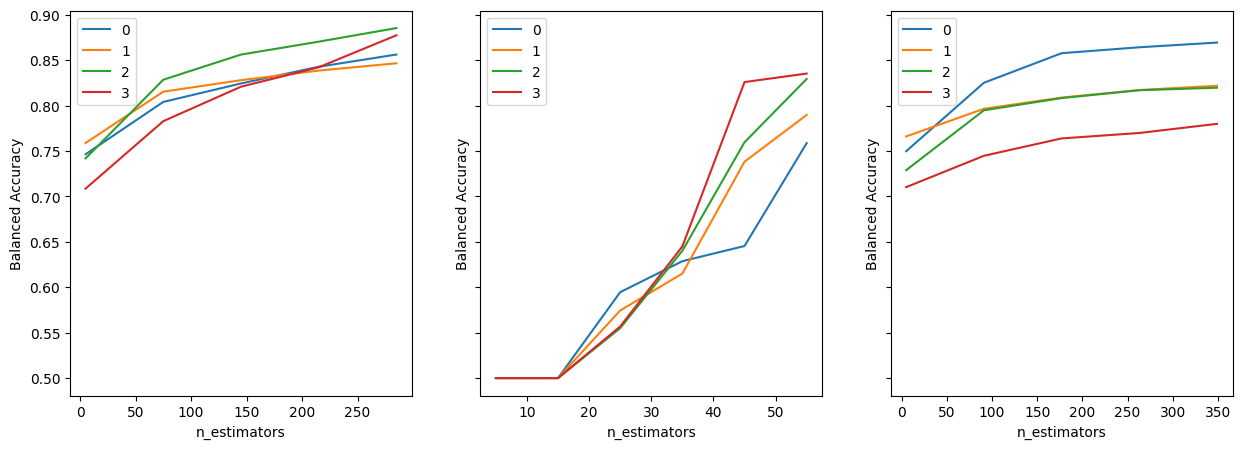

In [25]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 5), sharey = True)
model = LGBMClassifier(random_state=0, verbose = -1, **best_params["LGBMClassifier"])
df_eval = eval_model_optimization(model)
plot_eval_model_optimization(df_eval, axs[0])


model = FairGBMClassifier(random_state=0,  **best_params["FairGBMClassifier"])
df_eval = eval_model_optimization(model)
plot_eval_model_optimization(df_eval, axs[1])


model = M2FGB(random_state=0, **best_params["M2FGB"])
df_eval = eval_model_optimization(model)
plot_eval_model_optimization(df_eval, axs[2])

In [26]:
model = M2FGB(random_state=0, **best_params["M2FGB"])
model.fit(X_train, Y_train, A_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

M2FGB(fair_weight=1.3447315243797855, learning_rate=0.14670139074079722,
      max_depth=9, min_child_weight=1.5171386860277116, n_estimators=435,
      random_state=0, reg_lambda=0.055332431290605985)

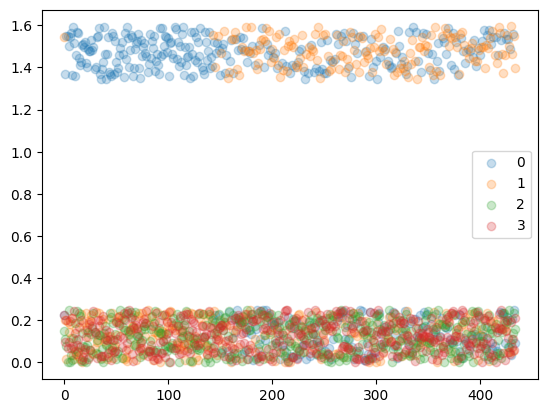

In [35]:
for i in range(4):
    plt.scatter(
        list(range(model.n_estimators)),
        model.mu_opt_list[:, i] + np.random.uniform(0, 0.25, size = (model.n_estimators)), 
        label = str(i), 
        alpha = 0.25
    )
plt.legend()
plt.show()

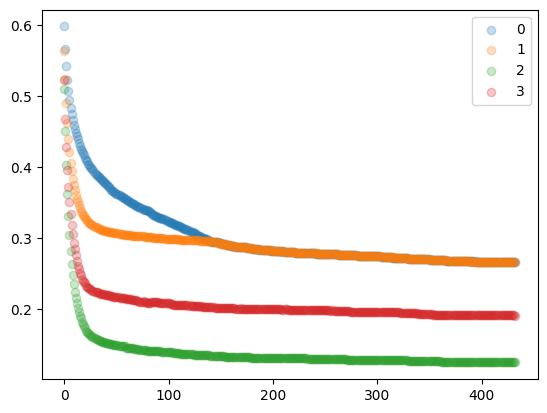

In [40]:
for i in range(4):
    plt.scatter(
        list(range(model.n_estimators -2)),
        model.group_losses[:, i],
        label = str(i), 
        alpha = 0.25
    )
plt.legend()
plt.show()

In [46]:
best_params_copy = best_params.copy()
best_params_copy["M2FGB"]["fair_weight"] = 0
model = M2FGB(random_state=0, **best_params_copy["M2FGB"])
model.fit(X_train, Y_train, A_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

M2FGB(fair_weight=0, learning_rate=0.14670139074079722, max_depth=9,
      min_child_weight=1.5171386860277116, n_estimators=435, random_state=0,
      reg_lambda=0.055332431290605985)

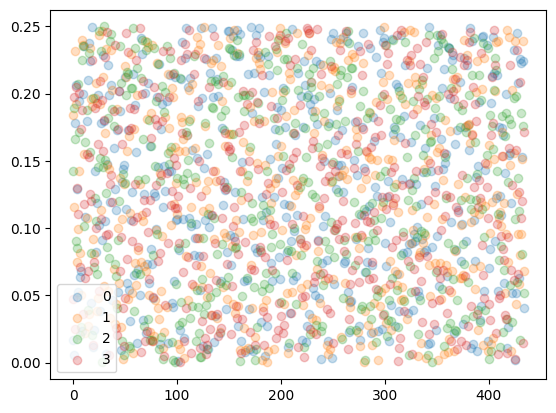

In [48]:
for i in range(4):
    plt.scatter(
        list(range(model.n_estimators)),
        model.mu_opt_list[:, i] + np.random.uniform(0, 0.25, size = (model.n_estimators)), 
        label = str(i), 
        alpha = 0.25
    )
plt.legend()
plt.show()

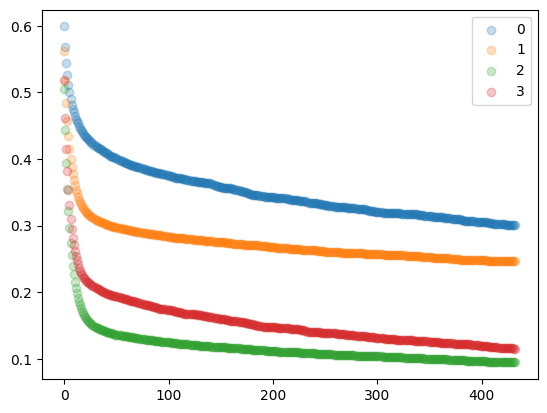

In [49]:
for i in range(4):
    plt.scatter(
        list(range(model.n_estimators -2)),
        model.group_losses[:, i],
        label = str(i), 
        alpha = 0.25
    )
plt.legend()
plt.show()

In [60]:
best_params_copy = best_params.copy()
best_params_copy["M2FGB"]["fair_weight"] = 10
best_params_copy["M2FGB"]["dual_learning"] = "gradient"
model = M2FGB(random_state=0, **best_params_copy["M2FGB"])
model.fit(X_train, Y_train, A_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


M2FGB(dual_learning='gradient', fair_weight=10,
      learning_rate=0.14670139074079722, max_depth=9,
      min_child_weight=1.5171386860277116, n_estimators=435, random_state=0,
      reg_lambda=0.055332431290605985)

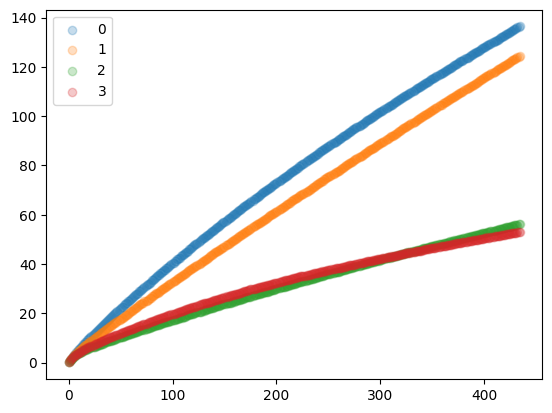

In [61]:
for i in range(4):
    plt.scatter(
        list(range(model.n_estimators)),
        model.mu_opt_list[:, i] + np.random.uniform(0, 0.25, size = (model.n_estimators)), 
        label = str(i), 
        alpha = 0.25
    )
plt.legend()
plt.show()

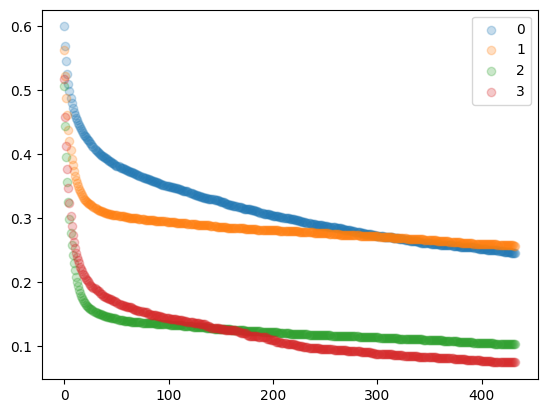

In [62]:
for i in range(4):
    plt.scatter(
        list(range(model.n_estimators -2)),
        model.group_losses[:, i],
        label = str(i), 
        alpha = 0.25
    )
plt.legend()
plt.show()

In [63]:
best_params_copy = best_params.copy()
best_params_copy["M2FGB"]["fair_weight"] = 10
best_params_copy["M2FGB"]["dual_learning"] = "optim"
model = M2FGB(random_state=0, **best_params_copy["M2FGB"])
model.fit(X_train, Y_train, A_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

M2FGB(fair_weight=10, learning_rate=0.14670139074079722, max_depth=9,
      min_child_weight=1.5171386860277116, n_estimators=435, random_state=0,
      reg_lambda=0.055332431290605985)

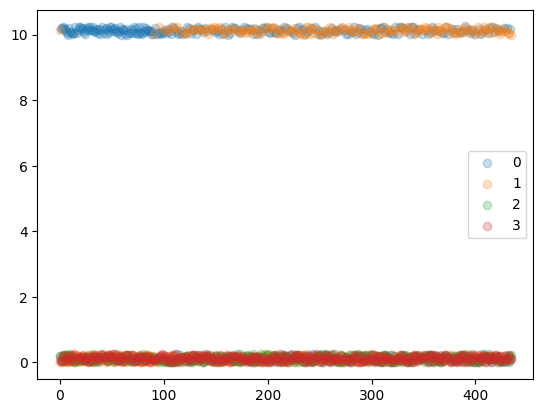

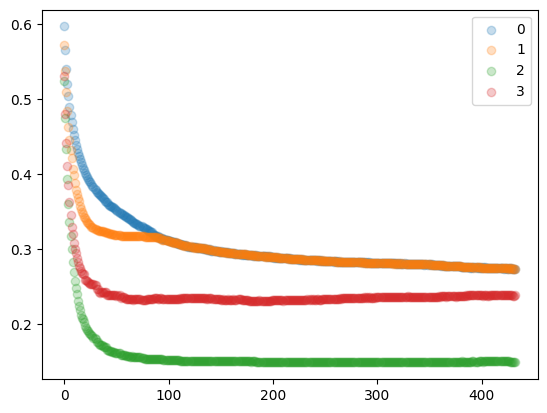

In [64]:
for i in range(4):
    plt.scatter(
        list(range(model.n_estimators)),
        model.mu_opt_list[:, i] + np.random.uniform(0, 0.25, size = (model.n_estimators)), 
        label = str(i), 
        alpha = 0.25
    )
plt.legend()
plt.show()

for i in range(4):
    plt.scatter(
        list(range(model.n_estimators -2)),
        model.group_losses[:, i],
        label = str(i), 
        alpha = 0.25
    )
plt.legend()
plt.show()